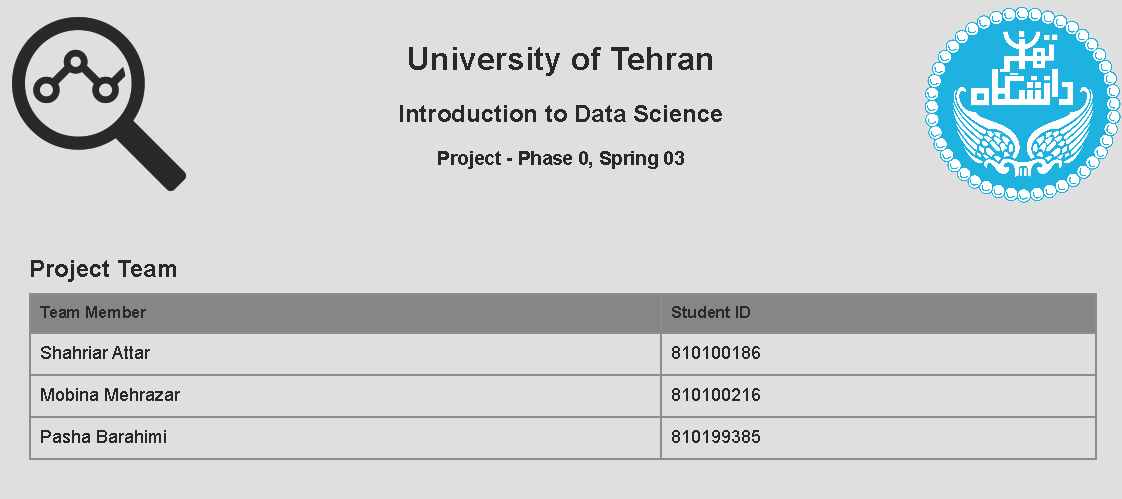

# <a id='toc1_'></a>[Project - Phase 0 - Data Gathering](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Project - Phase 0 - Data Gathering](#toc1_)    
  - [Introduction](#toc1_1_)    
  - [Environment Setup](#toc1_2_)    
  - [Tasks](#toc1_3_)    
    - [Finding the Last Page Number](#toc1_3_1_)    
    - [Finding the Car IDs per Page](#toc1_3_2_)    
    - [Extracting the Car Data](#toc1_3_3_)    
    - [The Procedure for Each Worker (Thread)](#toc1_3_4_)    
    - [Saving the Data to a CSV File](#toc1_3_5_)    
    - [Running the Scraping Process](#toc1_3_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introduction](#toc0_)

This phase is about gathering data from the web. We will use the BeautifulSoup library to scrape data from a website. The data we will scrape is the list of the car prices in South Africa. The website we will scrape is [www.webuycars.co.za](https://www.webuycars.co.za/).

## <a id='toc1_2_'></a>[Environment Setup](#toc0_)

Let's start by importing the necessary libraries.

In [26]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

from queue import Queue
from threading import Thread
from time import time, sleep
import logging
import csv

In [27]:
MAIN_PAGE_URL = "https://www.webuycars.co.za/buy-a-car?activeTypeSearch=[%22Vehicle%22]&Priced_Amount_Sort=%22desc%22"
SPECIFIED_PAGE_URL = MAIN_PAGE_URL + "&page={page_number}"
CAR_PAGE_URL = "https://www.webuycars.co.za/buy-a-car/{car_id}"

NUM_THREADS = 3
LOAD_WAIT_TIMEOUT = 20
SLEEP_TIME = 60 # 1 minute
NUMBER_OF_PAGES_BEFORE_SLEEP = 5

CARS_FILE = "../data/cars.csv"
LOG_FILE = "../logs/log.txt"

## <a id='toc1_3_'></a>[Tasks](#toc0_)

### <a id='toc1_3_1_'></a>[Finding the Last Page Number](#toc0_)

In [28]:
def find_last_page_number() -> int:
    driver = webdriver.Chrome()
    driver.get(MAIN_PAGE_URL)
    while True:  # Wait for the pagination to load
        try:
            driver.find_element(By.CLASS_NAME, "pagination")
            break
        except:
            pass
    last_page_link = driver.find_element(By.CLASS_NAME, "pagination").find_elements(By.TAG_NAME, "li")[-1].find_element(By.TAG_NAME, "a")
    last_page_link.click()
    last_page_number = driver.current_url.split("=")[-1]
    driver.quit()
    return int(last_page_number)

### <a id='toc1_3_2_'></a>[Finding the Car IDs per Page](#toc0_)

In [29]:
def get_car_ids(driver: webdriver.Chrome, page_number: int) -> list:
    driver.get(SPECIFIED_PAGE_URL.format(page_number=page_number))
    car_ids = []
    start_time = time()
    while True:  # Keep trying until the page loads
        try:
            driver.find_element(By.CLASS_NAME, "no-results-message")
            return []
        except:
            pass
        cars = driver.find_elements(By.CLASS_NAME, "grid-card")
        if len(cars) > 0:
            break
        if time() - start_time > LOAD_WAIT_TIMEOUT:
            raise TimeoutError("Page took too long to load")
    for car in cars:
        car_id = car.find_element(By.CSS_SELECTOR, "button[aria-label='Add Favourite']").get_attribute("data-stocknumber")
        car_ids.append(car_id)
    return car_ids


### <a id='toc1_3_3_'></a>[Extracting the Car Data](#toc0_)

In [30]:
def get_car_data(driver: webdriver.Chrome, car_id: str) -> dict:
    driver.get(CAR_PAGE_URL.format(car_id=car_id))
    start = time()
    while len(driver.find_elements(By.CLASS_NAME, "details-container")) == 0: # Keep trying until the page loads
        if time() - start > LOAD_WAIT_TIMEOUT:
            raise TimeoutError("Page load timeout")
        pass

    soup = BeautifulSoup(driver.page_source, "html.parser")
    car_data = {}
    car_data["id"] = car_id
    details_containers = soup.find_all("div", class_="details-container")
    for details in details_containers:
        datas = details.find_all("div", class_="flex-row")
        for data in datas:
            key = data.find("div").text
            try:
                value = data.find("strong").text
            except:
                continue
            if key[-1] == ":":
                key = key[:-1]
            car_data[key] = value

    features = []
    try:
        vehicle_features = soup.find("h2", string="VEHICLE FEATURES").next_sibling.find_all("div", class_="chip-text m-1")
        for feature in vehicle_features:
            features.append(feature.text)
    except:
        pass
    car_data["Features"] = features

    try:
        car_data["Price"] = soup.find("div", class_="price-text").find("span").text
    except:
        car_data["Price"] = soup.find("div", class_="wheel-text-middle").find("span").text
    car_data["Dekra"] = soup.find("img", alt="dekra").next_sibling.strip()
    try:
        car_data["Finance Price"] = soup.find("div", class_="finance-price").find("span").text
    except:
        car_data["Finance Price"] = None

    return car_data


In [31]:
def handle_car(car_id: str, thread_id: int, car_queue: Queue, driver: webdriver.Chrome) -> bool:
    failed = 0
    while True:
        try:
            logging.info(f"Thread {thread_id}: getting data for car {car_id}")
            car_data = get_car_data(driver, car_id)
            car_queue.put(car_data)
            return True
        except Exception as e:
            logging.error(f"Thread {thread_id}: Error getting data for car {car_id}: {e}")
            if "WebDriver session does not exist" in str(e):
                raise e
            if failed == 3:
                logging.error(f"Thread {thread_id}: Failed to get data for car {car_id} 3 times, skipping")
                return False
            else:
                failed += 1
                logging.error(f"Thread {thread_id}: Retrying car {car_id}")

### <a id='toc1_3_4_'></a>[The Procedure for Each Worker (Thread)](#toc0_)

In [32]:
def worker(car_queue: Queue, i: int, end_page: int, thread_id: int):
    logging.info(f"Thread {thread_id}: started at index {i}")
    failed_ids = []
    driver = webdriver.Chrome()
    while True:
        start_time = time()
        page_number = NUM_THREADS * i + thread_id
        if page_number > end_page:
            logging.info(f"Thread {thread_id}: finished")
            break
        logging.info(f"Thread {thread_id}: started page {page_number} (index {i})")
        try:
            car_ids = get_car_ids(driver, page_number)
        except Exception as e:
            logging.error(f"Thread {thread_id}: Error getting car ids for page {page_number}: {e}")
            if "WebDriver session does not exist" in str(e):
                return
            continue

        for car_id in car_ids:
            try:
                if not handle_car(car_id, thread_id, car_queue, driver):
                    failed_ids.append(car_id)
            except Exception as e:
                return
        i += 1
        logging.info(f"Thread {thread_id}: finished page {page_number} in {time()-start_time:.2f} seconds")

        if i % NUMBER_OF_PAGES_BEFORE_SLEEP == 0:
            logging.info(f"Thread {thread_id}: scraped {NUMBER_OF_PAGES_BEFORE_SLEEP}, sleeping for {SLEEP_TIME} seconds")
            sleep(SLEEP_TIME)
            logging.info(f"Thread {thread_id}: woke up")

    for car_id in failed_ids:
        try:
            if not handle_car(car_id, thread_id, car_queue, driver):
                logging.error(f"Thread {thread_id}: Repeated failure for car {car_id}, skipping")
        except Exception as e:
            return

    driver.quit()

### <a id='toc1_3_5_'></a>[Saving the Data to a CSV File](#toc0_)

In [33]:
def write_to_csv(cars: list[dict]):
    with open(CARS_FILE, "w", newline="", encoding="utf-8") as file:
        field_names = set()
        for car in cars:
            field_names.update(car.keys())
        writer = csv.DictWriter(file, fieldnames=field_names)
        writer.writeheader()

        for car in cars:
            writer.writerow(car)

### <a id='toc1_3_6_'></a>[Running the Scraping Process](#toc0_)

In [34]:
def queue_to_list(queue: Queue) -> list:
    result = []
    while not queue.empty():
        result.append(queue.get())
    return result

In [35]:
car_queue = Queue()

def main():
    global car_queue

    open(LOG_FILE, "w").close()
    logging.basicConfig(filename=LOG_FILE, level=logging.INFO, format='%(asctime)s [%(levelname)s] -> %(message)s')

    last_page_number = find_last_page_number() # change this for testing
    logging.info(f"Starting scrape until page {last_page_number}")
    threads = []
    start_time = time()
    for i in range(NUM_THREADS):
        thread = Thread(target=worker, args=(car_queue, 0, last_page_number, i + 1))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    logging.info(f"Finished in {time()-start_time:.2f} seconds")

    cars = queue_to_list(car_queue)
    write_to_csv(cars)

In [36]:
main()